# LDA

### Referencias

- [Twitter Topic Modeling](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence)
- [Reddit Machine Learning for Topic Analysis](https://machinelearninghd.com/reddit-machine-learning-sentiment-and-topic-analysis/)

In [1]:
import gensim.corpora as corpora
import nltk, spacy, gensim
import pickle
import numpy as np
from gensim.models import CoherenceModel
import pandas as pd
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
TEXT_FILE_READ = 'docs/preprocessing_reddit_data.csv'
TEXT_SAVE_FILE = 'docs/reddit_data_lda.csv'
FILENAME_PICKLE = "docs/tmpreddit.pickle"

In [3]:
with open(FILENAME_PICKLE, 'rb') as f:
    df = pickle.load(f)
    
#print(df['lemma_tokens'])

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma_tokens'])

#print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)

#print(len(id2word))

# Creating a corpus object
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]


In [5]:
min_topics = 15
max_topics = 45
step_size = 3
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
result = []

# iterate through number of topics
for a in alpha:
    current = {}

    coherence_values = []
    model_list = []

    # iterate through alpha values
    for k in topics_range:
        # get the coherence score for the given parameters
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=k,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=a,
                                                  per_word_topics=True)

        # Save the model results
        #print('-------------------------------')
        #print('Números de tópicos: ' + str(k))
        #print('Alpha: ' + str(a))

        #print('\nPerplexity: ', lda_model.log_perplexity(corpus))

        coherence_model_lda = CoherenceModel(model=lda_model, texts=df['lemma_tokens'], dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        #print('\nCoherence Score: ', coherence_lda)

        model_list.append(lda_model)
        coherence_values.append(coherence_lda)


    current['coherence_values'] = coherence_values
    current['model_list'] = model_list
    current['alpha'] = a
    result.append(current)

## Selección del número óptimo de tópicos y *alpha* a través de la medida de coherencia

La puntuación de coherencia parece aumentar con la cantidad de tópicos. No siempre es mejor dónde está el *C_v* más alto, por lo que podemos probar varios para encontrar el mejor resultado. Agregar tópicos puede ayudar a revelar más subtópicos. Sin embargo, si las mismas palabras comienzan a aparecer en varios tópicos, la cantidad de tópicos es demasiado alta.

Se revisaron los resultados de diferentes modelos, comenzando por aquellos que tienen el *C_v* más alto. Debido al acomplamiento entre varios tópicos, se descartaron los primeros dos. El tercero se descarto ya que consideré que tenía pocos tópicos y que el cuarto era más interesante en este sentido. Por lo tanto, se seleccionó como hiperparámetros óptimos el número de tópicos 42 y *alpha* 0.01.


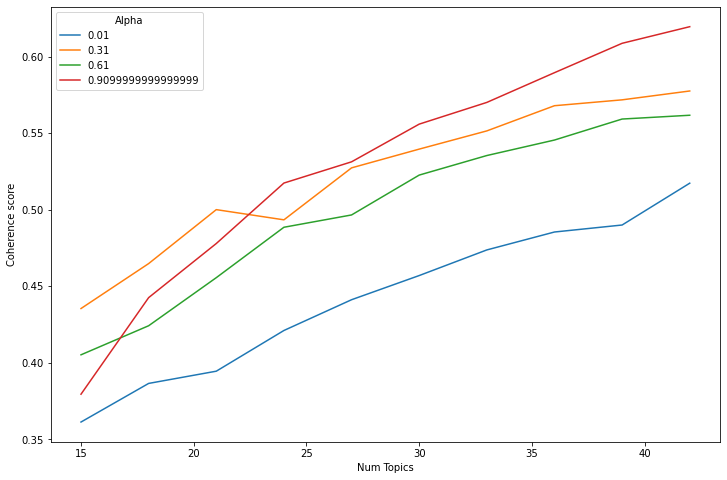

    Alpha  Num Topics  Coherence score
39   0.91          42         0.619534
38   0.91          39         0.608675
37   0.91          36         0.589480
19   0.31          42         0.577524
18   0.31          39         0.571736
36   0.91          33         0.570061
17   0.31          36         0.567902
29   0.61          42         0.561672
28   0.61          39         0.559193
35   0.91          30         0.555869


<Figure size 864x576 with 0 Axes>

In [6]:
plt.figure(figsize=(12, 8))
for current in result:
   plt.plot(topics_range, current['coherence_values'], label=current['alpha'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(title='Alpha', loc='best')
plt.show()

data = []

plt.figure(figsize=(12, 8))
for current in result:
    for index_num_topic, num_topic in enumerate(topics_range):
        data.append([current['alpha'], num_topic, current['coherence_values'][index_num_topic]])

df = pd.DataFrame(data,columns=['Alpha','Num Topics', 'Coherence score'])
df = df.sort_values(by='Coherence score', ascending=False)
print(df.head(10))

In [51]:
# Instantiating a Base LDA model
base_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=27,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=0.31,
                                                  per_word_topics=True)

In [52]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 0 
Words: ['milei', 'gracias', 'preguntar', 'llamar', 'post', 'x200b', 'peronismo', 'huevo', 'laburar', 'liberal', 'literalmente', 'xd', 'minuto', 'escuela', 'quer', 'vidal', 'mem', 'serie', 'egresado', 'santoro', 'regalar', 'viaje', 'lamentablemente', 'policía', 'lunes', 'bregmar', 'chupa', 'caño', 'razon', 'laboral']
Topic: 1 
Words: ['él', 'ver', 'hacer', 'poner', 'entender', 'político', 'mierda', 'llevar', 'palabra', 'flaco', 'hora', 'explicar', 'carne', 'san', 'interesante', 'ir', 'referir', 'don', 'formar', 'amor', 'ves', 'máximo', 'respeto', 'excelente', 'canilla', 'especial', 'necesitar', 'simplemente', 'altura', 'factura']
Topic: 2 
Words: ['país', 'empezar', 'cambiar', 'robar', 'vivo', 'nacional', 'k', 'historia', 'listo', 'fuerte', 'fondo', 'experiencia', 'papel', 'pelo', 'jajajaj', 'global', 'situación', 'calentamiento', 'lpm', 'fiesta', 'título', 'letra', 'club', 'amiga', 'regalo', 'organizar', 'gil', 'cana', 'rallado', 'falso']
Topic: 3 
Words: ['sacar', 'gobierno'

In [53]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.352129  0.024699       1        1  4.444384
24     0.017304  0.143536       2        1  4.155282
25     0.031423 -0.031854       3        1  3.998269
23     0.048987  0.117512       4        1  3.928668
13     0.060940 -0.043180       5        1  3.927842
14     0.028001  0.037303       6        1  3.921574
0     -0.001300  0.138069       7        1  3.863357
17     0.027508  0.089191       8        1  3.824787
3     -0.013600 -0.034192       9        1  3.790229
8     -0.006210  0.045849      10        1  3.736142
6      0.022025 -0.046883      11        1  3.679481
26    -0.001781 -0.147798      12        1  3.666862
12     0.022352  0.067030      13        1  3.664036
9      0.048055 -0.096512      14        1  3.625604
15     0.053161 -0.106165      15        1  3.613889
7      0.053248 -0.151624      16        1  3.613505
10     0.070015  0.141954      17        1  3.606232
5      0.007016 -0.104280      18        1  3.600882
4     -0.219105 -0.069788      19        1  3.576739
21    -0.094695  0.027624      20        1  3.550656
16     0.042306  0.003089      21        1  3.546147
2     -0.035490 -0.017965      22        1  3.522306
22     0.002451  0.058689      23        1  3.485512
11     0.051975  0.064378      24        1  3.463791
18     0.050296 -0.119305      25        1  3.432020
20     0.023136  0.063555      26        1  3.391858
19     0.064111 -0.052930      27        1  3.369946, topic_info=        Term         Freq        Total Category  logprob  loglift
223       él  1262.000000  1262.000000  Default  30.0000  30.0000
4243       ⠀   848.000000   848.000000  Default  29.0000  29.0000
4310       ⣿   643.000000   643.000000  Default  28.0000  28.0000
71     pasar   538.000000   538.000000  Default  27.0000  27.0000
177      ver   556.000000   556.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1640   datar    24.749580    27.317814  Topic27  -5.0655   3.2915
3847   lavar    24.205928    26.962278  Topic27  -5.0877   3.2824
640       it    37.676480    54.510976  Topic27  -4.6453   3.0209
3759  sufrir    25.466090    29.663906  Topic27  -5.0370   3.2377
76     salir    49.505376   423.997544  Topic27  -4.3722   1.2426

[1112 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
763      15  0.982714         +
586       8  0.987872        /s
2589     27  0.928614         =
1595      9  0.983676         >
927       4  0.981416  ^(reddit
...     ...       ...       ...
4544     24  0.787510         ️
2873      3  0.984589         😂
2724     20  0.932953         😃
5098     10  0.946713         😭
2874     18  0.970149         🤣

[1994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 25, 26, 24, 14, 15, 1, 18, 4, 9, 7, 27, 13, 10, 16, 8, 11, 6, 5, 22, 17, 3, 23, 12, 19, 21, 20])

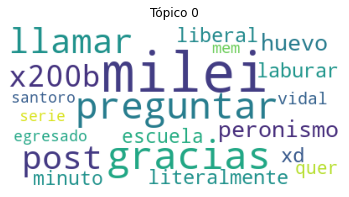

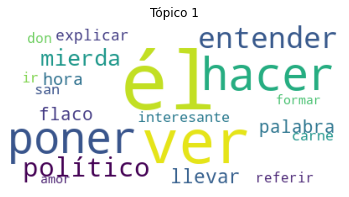

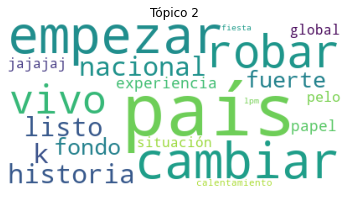

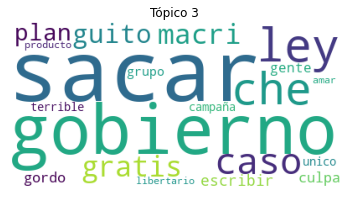

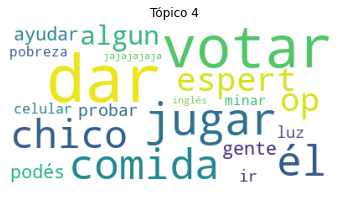

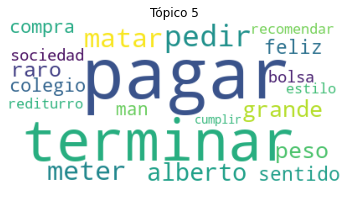

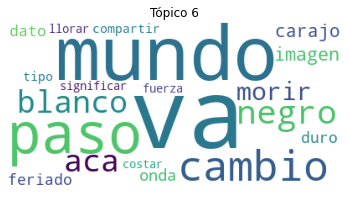

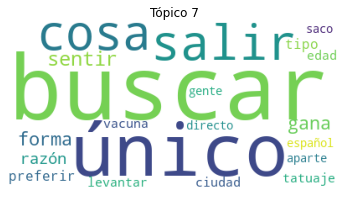

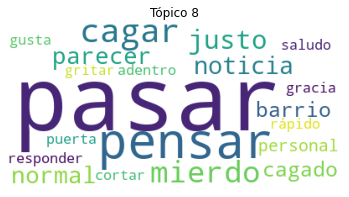

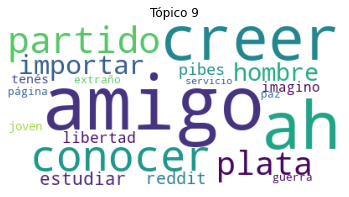

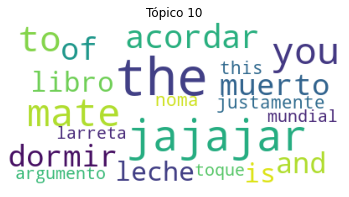

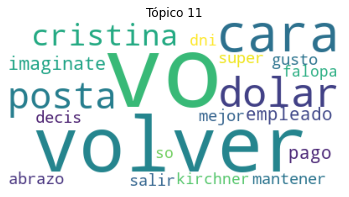

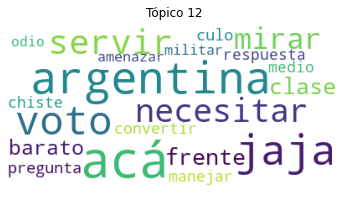

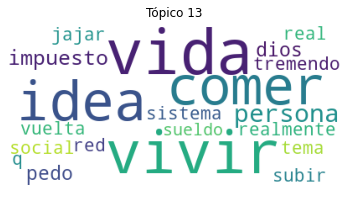

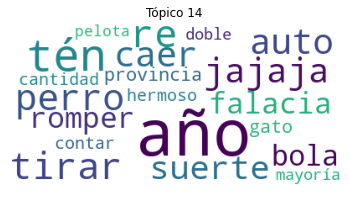

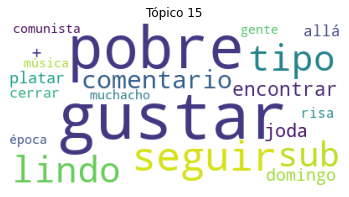

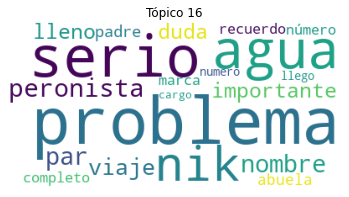

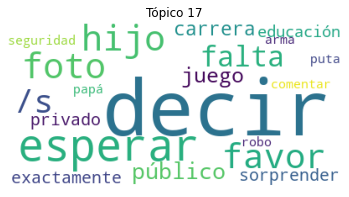

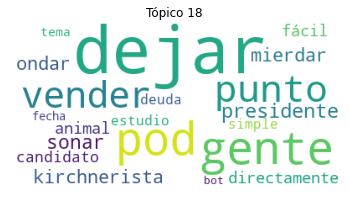

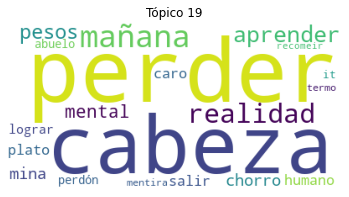

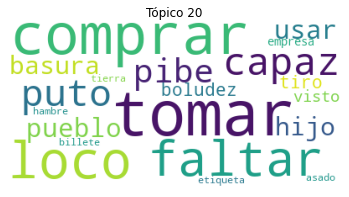

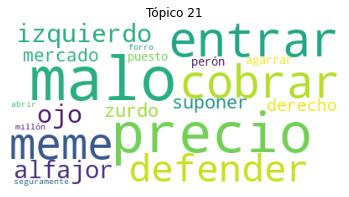

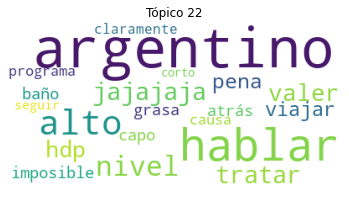

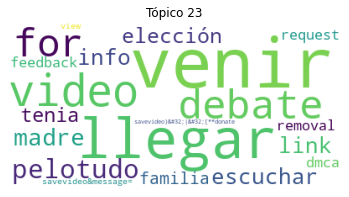

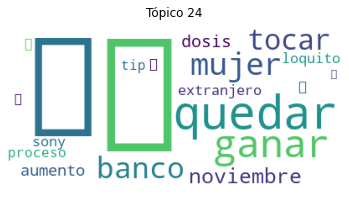

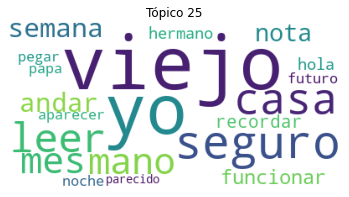

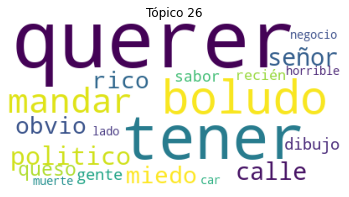

In [56]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(base_model.show_topic(index, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(index))
    plt.show()

In [57]:
reddit = pd.read_csv(TEXT_FILE_READ)

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # old line
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #ent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
                #print(sent_topics_df)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=base_model, corpus=corpus, texts=reddit)

In [58]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,score,id,flair,comms_num,body,comment_parent_id,is_replay,body_preprocessing
0,0,22.0,0.1503,"argentino, hablar, alto, nivel, tratar, jajaja...",1,hgw77qe,Política🏛️,0,"Iba a decir, bue si lo saco de su bolsillo... ...",q9imco,False,bue saco bolsillo recorder hdp mantener alcanz...
1,1,11.0,0.2031,"vo, volver, cara, dolar, posta, cristina, imag...",1,hgw7dci,Política🏛️,0,Se volvio un meme el bot del dolar?,hgw666m,True,volvio meme dolar
2,2,8.0,0.0941,"pasar, pensar, cagar, mierdo, justo, noticia, ...",1,hgw69er,Humor:snoo_joy:,0,Este Esteban Lamothe estaba en la ficción de u...,q9i4uj,False,ester lamothe ficción villo acá comedia políti...
3,3,23.0,0.2672,"venir, llegar, video, debate, for, pelotudo, m...",1,hgw6zvd,Meme💩,0,Eso porque son todos útos chupa bija.. Venga e...,hgw2528,True,úto chupa bijo venir ban nedflanducacion
4,4,23.0,0.1867,"venir, llegar, video, debate, for, pelotudo, m...",1,hgw24ns,Meme💩,0,mas verso burgués que Maximo no hay. Es la rep...,q9hut7,False,verso burgués maximo representación
5,5,4.0,0.2480,"dar, votar, jugar, él, comida, chico, espert, ...",1,hgw38x8,Meme💩,0,Ayudar con comida? Na mejor unos afiches a tod...,q9hut7,False,ayudar comida na afich color
6,6,22.0,0.1263,"argentino, hablar, alto, nivel, tratar, jajaja...",1,hgw2rml,Meme💩,1,¿Por qué si es un cerdo tiene 6 patas?,q9hut7,False,cerdo pata
7,7,25.0,0.1504,"viejo, yo, seguro, casa, leer, mes, mano, sema...",1,hgw3wei,Meme💩,0,"Mira, soy tan capitalista que por 15 mil pesos...",q9hut7,False,mira capitalisto pesos corrijo color
8,8,19.0,0.1067,"perder, cabeza, mañana, realidad, aprender, pe...",1,hgw78bv,Meme💩,0,Swinetaur libertario de Darkest Perónia. Ruin ...,q9hut7,False,swinetaur libertario darkest perónia ruin come...
9,9,2.0,0.1060,"país, empezar, cambiar, robar, vivo, nacional,...",1,hgw6rim,Meme💩,0,como no pueden contra elllll. lo ensucian vamo...,q9hut7,False,elllll ensuciar milie bastar k


In [59]:
df_dominant_topic.to_csv(TEXT_SAVE_FILE, index=False)